In [1]:
%matplotlib notebook

import numpy as np
import sympy as sym
import matplotlib.pyplot as plt

In [2]:
critChance = 1/6
surgedCritChance = 1 - (5/6 * 4/6)

In [5]:
averageFatePerRound = critChance + critChance + surgedCritChance + surgedCritChance
print(averageFatePerRound)

1.222222222222222


In [6]:
critChance

0.16666666666666666

In [7]:
surgedCritChance

0.4444444444444444

In [8]:
hitPoints = 12
attackAdvantage = 3


In [54]:
d6 = lambda n: np.random.randint(1,7,n)
def hasDoubles(arr):
    return len(np.unique(arr)) != len(arr)

In [49]:
class Attack:
    def __init__(self, advantage, damage, useReroll=False, surged=False):
        self.advantage = advantage
        self.damage = damage
        self.useReroll = useReroll
        self.surged = surged

In [68]:
knockoutChance = 4

def playerTurn(attacks, enemyHP, enemyArmor, fate, maxFate):
    kills = 0
    startingHP = enemyHP
    
    for a in attacks:
        #print("---")
        enemyHP, fate = attackAction(a.advantage, a.damage, enemyHP, enemyArmor, fate, maxFate, a.useReroll, a.surged)

        if enemyHP <=0 and d6(1) <= knockoutChance:
            fate = min(fate + 1, maxFate)
            #print("Scored a kill")
            kills = kills + 1
            enemyHP = startingHP

    return enemyHP, fate, kills

def attackAction(advantage, damage, enemyHP, enemyArmor, fate, maxFate, useReroll = False, surged=False):
    '''advantage = def - accuracy'''
    if(surged):
        attackRoll = d6(3)
    else:
        attackRoll = d6(2)
      
    #print("Rolled attack: " + str(attackRoll))
    attackTotal = np.sum(attackRoll) + advantage
    
    if(attackTotal > 0): # hit
        #print("Hit")
        if hasDoubles(attackRoll):
            fate = min(fate + 1, maxFate)
            #print("Regained fate")
        return scoreHit(damage, enemyHP, enemyArmor), fate
    
    # missed
    #print("Miss")
    if(useReroll and fate > 0):
        fate = fate - 1
        return attackAction(advantage, damage, enemyHP, enemyArmor, fate, maxFate, False, surged)
    
    return enemyHP, fate

def scoreHit(damage, enemyHP, enemyArmor):
    damage = np.sum(d6(2)) + damage - enemyArmor
    damage = max(damage, 0)
    enemyHP -= damage
    #print("Damage: " + str(damage))
    return enemyHP

In [69]:
defense = 11
attacks = [
    Attack(4 - defense, 12, useReroll=True, surged=False),
    Attack(4 - defense, 12, useReroll=True, surged=False),
    Attack(5 - defense, 11, useReroll=True, surged=False),
    Attack(5 - defense, 11, useReroll=True, surged=True)
]
enemyHP = 12
enemyArmor = 5
fate = 3
maxFate = 3

newHP, newFate, kills = playerTurn(attacks, enemyHP, enemyArmor, fate, maxFate)
print("-----")
print("HP: ", newHP)
print("Fate: ", newFate)
print("Kills: ", kills)

-----
HP:  12
Fate:  3
Kills:  3


In [88]:
iterations = 1000

defenses = np.arange(10, 20)
enemyHP = 12
enemyArmor = 8
fate = 3
maxFate = 3
scoredKills = np.zeros(np.size(defenses))
fateRemaining = np.zeros(np.size(defenses))

for d, defense in enumerate(defenses):
    lightningRound = [
        Attack(6 - defense - 4, 12, useReroll=True, surged=False),
        Attack(6 - defense - 4, 12, useReroll=True, surged=False),
        Attack(5 - defense, 11, useReroll=True, surged=False),
        Attack(5 - defense, 11, useReroll=True, surged=True)
    ]
    
    for i in range(iterations):
        _, fateAfter, kills = playerTurn(lightningRound, enemyHP, enemyArmor, fate, maxFate)
        scoredKills[d] += kills
        fateRemaining[d] += fateAfter
        
# normalize
scoredKills = scoredKills / iterations
fateRemaining = fateRemaining / iterations

<IPython.core.display.Javascript object>


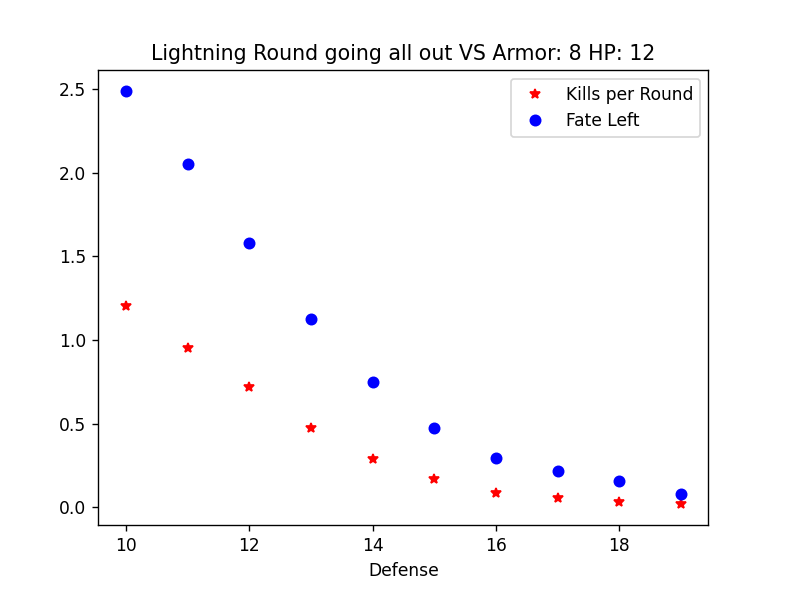

In [89]:
fig, ax = plt.subplots(1,1)
ax.plot(defenses, scoredKills, 'r*')
ax.plot(defenses, fateRemaining, 'bo')
ax.set_title("Lightning Round going all out VS " + "Armor: " + str(enemyArmor) + " HP: " + str(enemyHP))
ax.set_xlabel("Defense")
ax.legend(["Kills per Round", "Fate Left"])

In [72]:
scoredKills

array([2.081, 1.815, 1.478, 1.186, 0.759, 0.457, 0.23 , 0.124, 0.081,
       0.049])

In [73]:
fateRemaining

array([2.862, 2.677, 2.264, 1.824, 1.215, 0.765, 0.45 , 0.271, 0.195,
       0.112])